In [1]:
import wandb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# the best set of hyperparameters that we get from the sweep
default_parameters = dict(
    n_layers= 4,
    hidden_layer_size= 128,
    learn_rate= 1e-3,
    batch_size = 16,
    epochs=10,
    alpha = 0,
    optimizer = "nadam",
    activation = "relu",
    weight_init = "random"
    )
config = default_parameters

In [3]:
run = wandb.init(config= default_parameters,project="cs6910_assignment_1", entity="neilghosh")
config = wandb.config

wandb: Currently logged in as: arneshbose1 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
#import the data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#store the image class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

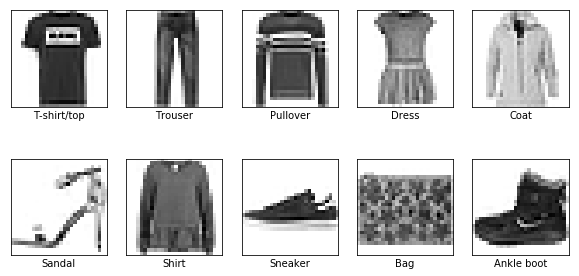

In [5]:
# plot one sample image from each class
sample_images = []
plt.figure(figsize=(10,5))
for i in range(len(class_names)):
    sample_images.append(train_labels.tolist().index(i))
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[sample_images[i]], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[sample_images[i]]])
    
wandb.log({"sample_images": plt})

In [6]:
# convert integer to one-hot vector
def one_hot_vector(x):
    y = np.zeros((x.size, x.max()+1))
    y[np.arange(x.size),x] = 1
    return y

In [7]:
def activation_func(z, activation="sigmoid"):
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif activation == "softmax":
        z1 = np.exp(z)
        z2 = z1.sum(axis=1)
        z2 = np.dstack([z2])
        return z1/z2
    elif activation == "tanh":
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    elif activation == "relu":
        return np.maximum(0, z)

    else:
        return "Error"

In [8]:
def activation_derivative(z, activation="sigmoid"):
    if activation == "sigmoid":
      sig = 1 / (1 + np.exp(-z))
      return sig*(1-sig)
    elif activation == "tanh":
      tanh = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
      return 1 - tanh**2
    elif activation == "relu":
      relu = np.maximum(0, z)
      relu[relu > 0] = 1
      return relu
    else:
      return "Error"

In [9]:
# training on the entire data set
input_size = train_images.shape[1]*train_images.shape[2]
output_size = len(class_names)

train_x = train_images.reshape([train_images.shape[0], input_size, 1])/255
test_x = test_images.reshape([test_images.shape[0], input_size, 1])/255

# shuffle the training data
indices = np.arange(train_x.shape[0])
np.random.shuffle(indices)

train_y = one_hot_vector(train_labels)
test_y = one_hot_vector(test_labels)

train_x = train_x[indices]
train_y = train_y[indices]

train_y = np.dstack([train_y])
test_y = np.dstack([test_y])

In [10]:
nn_layers = [{"input_dim" : input_size, "output_dim" : config.hidden_layer_size, "activation" : config.activation}]
for i in range(config.n_layers-1):
  nn_layers.append({"input_dim" : config.hidden_layer_size, "output_dim" : config.hidden_layer_size, "activation" : config.activation})
nn_layers.append({"input_dim" : config.hidden_layer_size, "output_dim" : output_size, "activation" : "softmax"})

In [11]:
def init_layers(nn_layers, weight_init, seed = 45):
    np.random.seed(seed)
    weights = {}

    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        if weight_init == "random":
          weights['w' + str(layer_no)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
          weights['b' + str(layer_no)] = np.random.randn(layer_output_size, 1) * 0.1
        elif weight_init == "xavier":
          limit = np.sqrt(6/(layer_input_size + layer_output_size))
          weights['w' + str(layer_no)] = np.random.uniform(-limit, limit, size=(layer_output_size, layer_input_size))
          weights['b' + str(layer_no)] = np.random.uniform(-limit, limit, size=(layer_output_size, 1))
        else:
          return "Error - Weight Initialization"

    return weights

In [12]:
def forward_prop(train_x, weights, nn_layers):
    layer_output = {}
    h_curr = train_x

    layer_output["h0"] = train_x
    layer_output["a0"] = train_x

    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        h_prev = h_curr

        activation = layer["activation"]
        w_curr = weights["w" + str(layer_no)]
        b_curr = weights["b" + str(layer_no)]

        a_curr = np.matmul(w_curr, h_prev) + b_curr
        h_curr = activation_func(a_curr, activation)

        layer_output["a" + str(layer_no)] = a_curr
        layer_output["h" + str(layer_no)] = h_curr

    return h_curr, layer_output

In [13]:
# cross entropy loss + regularization

def loss_func(y_hat, y, alpha, weights, nn_layers,func='cross_entropy'):
    loss = 0
    if func=='cross_entropy':
        loss = -np.multiply(y, np.log(y_hat)).sum() / len(y_hat)
    elif func=='squared_loss':
        squared_diff = np.square(y-y_hat)
        loss = squared_diff.sum()/(2*len(y_hat))

    l2_reg = 0
    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        l2_reg += np.sum(weights["w" + str(layer_no)] ** 2)

    l2_reg = (alpha / 2) * l2_reg / len(y_hat)

    return loss + l2_reg

# accuracy
def accuracy_func(y_hat, train_y):
    correct_pred = np.argmax(y_hat, axis = 1) == np.argmax(train_y, axis = 1)
    return sum(bool(x) for x in correct_pred)/len(y_hat)

In [14]:
def back_prop(y_hat, y, layer_output, weights, nn_layers, alpha, func='cross_entropy'):
    gradients = {}
    
    m = len(y_hat)

    da_prev = np.zeros(y_hat.shape)

    if func=='cross_entropy':
        da_prev = -(y - y_hat)
    elif func=='squared_loss':
        y_label = np.where(y[:,:,0] == 1)[1]
        da_prev = np.zeros(y_hat.shape)
        for i in range(m):
            y_l_hat = np.ones((y_hat.shape[1],y_hat.shape[2]))*y_hat[:,y_label[i]][i]
            da_prev[i] = np.multiply(np.square(y_hat - y)[i], y_l_hat)
    else:
        da_prev = np.zeros(y_hat.shape)
        print("Error - wrong loss function")
            
    for i, layer in reversed(list(enumerate(nn_layers))):
        layer_index = i + 1

        da_curr = da_prev

        a_prev = layer_output["a" + str(i)]
        h_prev = layer_output["h" + str(i)]
        dh_prev = np.zeros(h_prev.shape)

        a_curr = layer_output["a" + str(layer_index)]
        w_curr = weights["w" + str(layer_index)]
        b_curr = weights["b" + str(layer_index)]
        dw_curr = np.zeros(w_curr.shape)
        db_curr = np.zeros(b_curr.shape)

        for j in range(m):
            dw_curr += np.dot(da_curr[j], h_prev[j].T)
            db_curr += da_curr[j]
            dh_prev[j] = np.dot(w_curr.T, da_curr[j])

        dw_curr += alpha * w_curr

        dw_curr /= m
        db_curr /= m

        if i > 0:
            activation = nn_layers[i - 1]["activation"]
            da_prev = np.multiply(dh_prev, activation_derivative(a_prev, activation))

        gradients["dw" + str(layer_index)] = dw_curr
        gradients["db" + str(layer_index)] = db_curr

    return gradients

In [15]:
def calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha,func='cross_entropy'):

    y_hat, layer_output = forward_prop(train_x, weights, nn_layers)
    training_loss = (loss_func(y_hat, train_y, alpha, weights, nn_layers,func))
    training_accuracy = (accuracy_func(y_hat, train_y))

    y_hat, layer_output = forward_prop(test_x, weights, nn_layers)
    test_loss = (loss_func(y_hat, test_y, alpha, weights, nn_layers,func))
    test_accuracy = (accuracy_func(y_hat, test_y))

    wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy, "test_loss": test_loss, "test_accuracy": test_accuracy})

    return training_loss, training_accuracy, test_loss, test_accuracy

In [16]:
def gradient_descent(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func='cross_entropy'):

  training_loss_list = []
  training_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha,func)

        for k, layer in enumerate(nn_layers):
          weights["w" + str(k+1)] -= eta * gradients["dw" + str(k+1)]
          weights["b" + str(k+1)] -= eta * gradients["db" + str(k+1)]

    training_loss, training_accuracy, test_loss, test_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha,func)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " epochs completed")

  return weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list

In [17]:
def momentum_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func='cross_entropy'):

  training_loss_list = []
  training_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  prev_weights = {}

  gamma = 0.9

  for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)
          prev_weights["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha,func)

        for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = gamma * prev_weights["w" + str(k+1)] + eta * gradients["dw" + str(k+1)]
          prev_weights["b" + str(k+1)] = gamma * prev_weights["b" + str(k+1)] + eta * gradients["db" + str(k+1)]

          weights["w" + str(k+1)] -= prev_weights["w" + str(k+1)]
          weights["b" + str(k+1)] -= prev_weights["b" + str(k+1)]


    training_loss, training_accuracy, test_loss, test_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha,func)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list


In [18]:
def nesterov_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func='cross_entropy'):
    training_loss_list = []
    training_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []

    batch_x = np.array(np.array_split(train_x, n_batches))
    batch_y = np.array(np.array_split(train_y, n_batches))

    prev_weights = {}
    look_ahead_w = {}

    gamma = 0.9

    for k, layer in enumerate(nn_layers):
        prev_weights["w" + str(k + 1)] = np.zeros(weights["w" + str(k + 1)].shape)
        prev_weights["b" + str(k + 1)] = np.zeros(weights["b" + str(k + 1)].shape)

    for i in range(epochs):
        for j in range(n_batches):

            for k, layer in enumerate(nn_layers):
                look_ahead_w["w" + str(k + 1)] = weights["w" + str(k + 1)] - gamma * prev_weights["w" + str(k + 1)]
                look_ahead_w["b" + str(k + 1)] = weights["b" + str(k + 1)] - gamma * prev_weights["b" + str(k + 1)]

            y_hat, layer_output = forward_prop(batch_x[j], look_ahead_w, nn_layers)
            gradients = back_prop(y_hat, batch_y[j], layer_output, look_ahead_w, nn_layers, alpha,func)

            for k, layer in enumerate(nn_layers):
                prev_weights["w" + str(k + 1)] = gamma * prev_weights["w" + str(k + 1)] + eta * gradients[
                    "dw" + str(k + 1)]
                prev_weights["b" + str(k + 1)] = gamma * prev_weights["b" + str(k + 1)] + eta * gradients[
                    "db" + str(k + 1)]

                weights["w" + str(k + 1)] -= prev_weights["w" + str(k + 1)]
                weights["b" + str(k + 1)] -= prev_weights["b" + str(k + 1)]

        training_loss, training_accuracy, test_loss, test_accuracy = calculate_loss_accuracy(train_x,train_y,test_x, test_y,weights,nn_layers, alpha,func)

        training_loss_list.append(training_loss)
        training_accuracy_list.append(training_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print((str(i + 1)) + "/" + str(epochs) + " completed")

    return weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list

In [19]:
def rmsprop(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func='cross_entropy'):

  training_loss_list = []
  training_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}

  beta = 0.9
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha,func)

        for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = beta * v["w" + str(k+1)] + (1-beta) * gradients["dw" + str(k+1)]**2
          v["b" + str(k+1)] = beta * v["b" + str(k+1)] + (1-beta) * gradients["db" + str(k+1)]**2

          weights["w" + str(k+1)] -= eta * np.divide(gradients["dw" + str(k+1)], np.sqrt(v["w" + str(k+1)] + epsilon))
          weights["b" + str(k+1)] -= eta * np.divide(gradients["db" + str(k+1)], np.sqrt(v["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, test_loss, test_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha,func)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list

In [20]:
def adam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func='cross_entropy'):

  training_loss_list = []
  training_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}
  v_hat = {}
  m = {}
  m_hat = {}

  beta1 = 0.9
  beta2 = 0.999
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)
          m["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)
          m["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)

  t = 0

  for i in range(epochs):
    for j in range(n_batches):

        t += 1

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers, alpha,func)

        for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = beta2 * v["w" + str(k+1)] + (1-beta2) * gradients["dw" + str(k+1)]**2
          v["b" + str(k+1)] = beta2 * v["b" + str(k+1)] + (1-beta2) * gradients["db" + str(k+1)]**2

          m["w" + str(k+1)] = beta1 * m["w" + str(k+1)] + (1-beta1) * gradients["dw" + str(k+1)]
          m["b" + str(k+1)] = beta1 * m["b" + str(k+1)] + (1-beta1) * gradients["db" + str(k+1)]

          v_hat["w" + str(k+1)] = np.divide(v["w" + str(k+1)], (1-beta2**t))
          v_hat["b" + str(k+1)] = np.divide(v["b" + str(k+1)], (1-beta2**t))

          m_hat["w" + str(k+1)] = np.divide(m["w" + str(k+1)], (1-beta1**t))
          m_hat["b" + str(k+1)] = np.divide(m["b" + str(k+1)], (1-beta1**t))

          weights["w" + str(k+1)] -= eta * np.divide(m_hat["w" + str(k+1)], np.sqrt(v_hat["w" + str(k+1)] + epsilon))
          weights["b" + str(k+1)] -= eta * np.divide(m_hat["b" + str(k+1)], np.sqrt(v_hat["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, test_loss, test_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers, alpha,func)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list

In [21]:
def nadam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func='cross_entropy'):
    training_loss_list = []
    training_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []

    batch_x = np.array(np.array_split(train_x, n_batches))
    batch_y = np.array(np.array_split(train_y, n_batches))

    v = {}
    v_hat = {}
    m = {}
    m_hat = {}

    look_ahead_w = {}
    look_ahead_m_hat = {}
    look_ahead_v_hat = {}

    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for k, layer in enumerate(nn_layers):
        v["w" + str(k + 1)] = np.zeros(weights["w" + str(k + 1)].shape)
        v["b" + str(k + 1)] = np.zeros(weights["b" + str(k + 1)].shape)
        m["w" + str(k + 1)] = np.zeros(weights["w" + str(k + 1)].shape)
        m["b" + str(k + 1)] = np.zeros(weights["b" + str(k + 1)].shape)

    t = 0

    for i in range(epochs):
        for j in range(n_batches):

            t += 1

            for k, layer in enumerate(nn_layers):
                look_ahead_v_hat["w" + str(k + 1)] = np.divide(beta2 * v["w" + str(k + 1)], (1 - beta2 ** t))
                look_ahead_v_hat["b" + str(k + 1)] = np.divide(beta2 * v["b" + str(k + 1)], (1 - beta2 ** t))

                look_ahead_m_hat["w" + str(k + 1)] = np.divide(beta1 * m["w" + str(k + 1)], (1 - beta1 ** t))
                look_ahead_m_hat["b" + str(k + 1)] = np.divide(beta1 * m["b" + str(k + 1)], (1 - beta1 ** t))

                look_ahead_w["w" + str(k + 1)] = weights["w" + str(k + 1)] - eta * np.divide(
                    look_ahead_m_hat["w" + str(k + 1)], np.sqrt(look_ahead_v_hat["w" + str(k + 1)] + epsilon))
                look_ahead_w["b" + str(k + 1)] = weights["b" + str(k + 1)] - eta * np.divide(
                    look_ahead_m_hat["b" + str(k + 1)], np.sqrt(look_ahead_v_hat["b" + str(k + 1)] + epsilon))

            y_hat, layer_output = forward_prop(batch_x[j], look_ahead_w, nn_layers)
            gradients = back_prop(y_hat, batch_y[j], layer_output, look_ahead_w, nn_layers, alpha,func)

            for k, layer in enumerate(nn_layers):
                v["w" + str(k + 1)] = beta2 * v["w" + str(k + 1)] + (1 - beta2) * gradients["dw" + str(k + 1)] ** 2
                v["b" + str(k + 1)] = beta2 * v["b" + str(k + 1)] + (1 - beta2) * gradients["db" + str(k + 1)] ** 2

                m["w" + str(k + 1)] = beta1 * m["w" + str(k + 1)] + (1 - beta1) * gradients["dw" + str(k + 1)]
                m["b" + str(k + 1)] = beta1 * m["b" + str(k + 1)] + (1 - beta1) * gradients["db" + str(k + 1)]

                v_hat["w" + str(k + 1)] = np.divide(v["w" + str(k + 1)], (1 - beta2 ** t))
                v_hat["b" + str(k + 1)] = np.divide(v["b" + str(k + 1)], (1 - beta2 ** t))

                m_hat["w" + str(k + 1)] = np.divide(m["w" + str(k + 1)], (1 - beta1 ** t))
                m_hat["b" + str(k + 1)] = np.divide(m["b" + str(k + 1)], (1 - beta1 ** t))

                weights["w" + str(k + 1)] -= eta * np.divide(m_hat["w" + str(k + 1)],
                                                             np.sqrt(v_hat["w" + str(k + 1)] + epsilon))
                weights["b" + str(k + 1)] -= eta * np.divide(m_hat["b" + str(k + 1)],
                                                             np.sqrt(v_hat["b" + str(k + 1)] + epsilon))

        training_loss, training_accuracy, test_loss, test_accuracy = calculate_loss_accuracy(train_x,train_y,test_x, test_y,weights,nn_layers, alpha,func)

        training_loss_list.append(training_loss)
        training_accuracy_list.append(training_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print((str(i + 1)) + "/" + str(epochs) + " completed")

    return weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list

In [22]:
def train(train_x, train_y, test_x, test_y, nn_layers, epochs, eta, batch_size, optimizer, weight_init, alpha,
          func='cross_entropy'):
    weights = init_layers(nn_layers, weight_init)

    n_batches = len(train_x) // batch_size

    if optimizer == "gradient_descent":
        weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list = gradient_descent(
            train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func)

    elif optimizer == "momentum_gradient_descent":
        weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list = momentum_gd(
            train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func)

    elif optimizer == "nesterov_accelerated_gradient_descent":
        weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list = nesterov_gd(
            train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func)

    elif optimizer == "rmsprop":
        weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list = rmsprop(
            train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func)

    elif optimizer == "adam":
        weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list = adam(
            train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func)

    elif optimizer == "nadam":
        weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list = nadam(
            train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches, alpha,func)

    else:
        return "Error - Wrong Optimizer"

    return weights, training_loss_list, training_accuracy_list, test_loss_list, test_accuracy_list

In [23]:
eta = config.learn_rate
epochs = config.epochs
batch_size = config.batch_size
optimizer = config.optimizer
weight_init = config.weight_init
alpha = config.alpha

# batch_size = 1 for stochastic and batch_size = len(train_x) for batch updates
#available_optimizers = ["gradient_descent", "momentum_gradient_descent", "nesterov_accelerated_gradient_descent", "rmsprop", "adam", "nadam"]

weights, train_loss, train_accuracy, test_loss, test_accuracy = train(train_x, train_y, test_x, test_y, nn_layers, epochs, eta, batch_size, optimizer, weight_init, alpha,func='cross_entropy')

1/10 completed
2/10 completed
3/10 completed
4/10 completed
5/10 completed
6/10 completed
7/10 completed
8/10 completed
9/10 completed
10/10 completed


In [24]:
# save the optimized weights
with open('weights.pickle', 'wb') as handle:
    pickle.dump(weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load previously saved weights
with open('weights.pickle', 'rb') as handle:
    weights = pickle.load(handle)

In [25]:
train_loss

[0.36828835811388255,
 0.3249797423326323,
 0.3087537292946356,
 0.30540125228797793,
 0.2982898713687454,
 0.28359473162178495,
 0.25095979071028673,
 0.25881762222274585,
 0.25214937231774937,
 0.24082334119071364]

In [26]:
train_accuracy

[0.864,
 0.8810666666666667,
 0.8878,
 0.8866666666666667,
 0.8871333333333333,
 0.8960666666666667,
 0.9052333333333333,
 0.9044666666666666,
 0.9041333333333333,
 0.9088833333333334]

In [27]:
config

{'n_layers': 4, 'hidden_layer_size': 128, 'learn_rate': 0.001, 'batch_size': 16, 'epochs': 10, 'alpha': 0, 'optimizer': 'nadam', 'activation': 'relu', 'weight_init': 'random'}

In [29]:
test_accuracy

[0.8508,
 0.8602,
 0.8665,
 0.8656,
 0.8651,
 0.8728,
 0.8828,
 0.8793,
 0.8764,
 0.8762]

In [31]:
test_loss

[0.4131814313432518,
 0.3808898160213578,
 0.38123229654930535,
 0.3853963410943291,
 0.3847895721349928,
 0.3797932195219869,
 0.362277435188562,
 0.3781911944795003,
 0.3748973560956223,
 0.36904045586753553]

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [34]:
train_y_vec = np.argmax(train_y,axis=1)
test_y_vec = np.argmax(test_y,axis=1)
y_hat_train,layer_train_output = forward_prop(train_x, weights, nn_layers)
y_hat_test,layer_test_output = forward_prop(test_x, weights, nn_layers)
y_hat_train = np.argmax(y_hat_train,axis=1)
y_hat_test = np.argmax(y_hat_test,axis=1)
cm_train = confusion_matrix(train_y_vec,y_hat_train)
cm_test = confusion_matrix(test_y_vec,y_hat_test)
print('Training Confusion Matrix\n')
print(cm_train)
print('\n\nTest Confusion Matrix\n')
print(cm_test)

Training Confusion Matrix

[[5402    5   62  117   20    4  353    0   37    0]
 [   5 5894    2   63   20    0    8    1    6    1]
 [  42    1 4570   72  790    1  504    0   20    0]
 [ 105   14   13 5559  243    0   52    0   14    0]
 [   1    3  244  132 5327    1  258    0   34    0]
 [   1    1    0    0    0 5907    0   76    0   15]
 [ 794    3  250  119  433    0 4343    0   58    0]
 [   0    0    0    0    0   20    0 5897    3   80]
 [   3    1    3    7   18    3   13    1 5951    0]
 [   0    0    0    0    0   22    0  293    2 5683]]


Test Confusion Matrix

[[862   1  15  24   6   1  81   0  10   0]
 [  3 970   1  16   6   0   4   0   0   0]
 [ 16   0 702  17 147   0 116   0   2   0]
 [ 23   7  12 884  49   0  16   0   9   0]
 [  1   0  64  32 840   0  57   0   6   0]
 [  0   0   0   0   0 954   0  34   1  11]
 [133   2  49  35  91   0 674   0  16   0]
 [  0   0   0   0   0   9   0 970   0  21]
 [  5   0   1   2   3   4   5   4 976   0]
 [  0   0   0   1   0   5   1 

Training Confusion Matrix



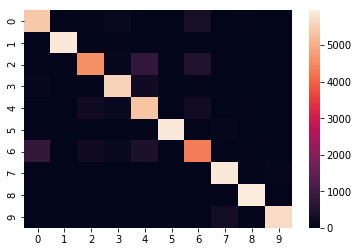

In [35]:
print('Training Confusion Matrix\n')
ax_train = sns.heatmap(cm_train)
wandb.log({"Confusion Matrix Train": wandb.Image(ax_train)})

Test Confusion Matrix



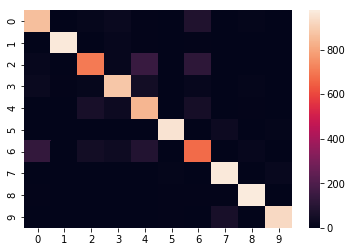

In [36]:
print('Test Confusion Matrix\n')
ax_test = sns.heatmap(cm_test)
wandb.log({"Confusion Matrix Test": wandb.Image(ax_test)})